In [1]:
import pandas as pd
import numpy as np

import torch
import torch.optim as optim

import matplotlib.pyplot as plt

Analisis

## Parameters and Hiperparameters

In [2]:
#Parameters to handle data
batch_size = 10
train_valid_percentage = 0.8
test_percentage = 0.2

In [3]:
#Hiperparameters
n_epochs = 400
sgd_lr = 0.05

## Data loading

In [4]:
datos = pd.read_csv("datos_filtrados.csv",index_col=0)

In [5]:
datos.head()

,AdaptivityLevel,Boy,Girl,1-5,11-15,16-20,21-25,26-30,6-10,College,...,NET_3G,NET_4G,Durat_0,Durat_1-3,Durat_3-6,LMS_No,LMS_Yes,Computer,Mobile,Tab
0,1,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,1,0,0,0,1
1,1,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
2,1,0,1,0,0,1,0,0,0,1,...,0,1,0,1,0,1,0,0,1,0
3,1,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
4,0,0,1,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0


In [6]:
target = datos["AdaptivityLevel"]
datos.drop("AdaptivityLevel",inplace=True,axis=1)
target.head()

0    1
1    1
2    1
3    1
4    0
Name: AdaptivityLevel, dtype: int64

In [7]:
classes = target.unique()
classes

array([1, 0, 2], dtype=int64)

## Separation of training, validation and test data

Se crea un función para llevar los datos desde Dataframe hacia Dataloders de Torch, pasando por tensores y Dataset de Tensores.

In [8]:
def createLoader(data,target):
    dataV = data.to_numpy() #convertir fila de Dataframe Datos a arreglo
    targetV = target.to_numpy() #convertir fila de Dataframe Target a arreglo
    #targetV = np.reshape(target.to_numpy(),(-1,1)) #cambiar arreglo a matrix nx1

    dataV = torch.from_numpy(dataV).type(torch.FloatTensor)
    targetV = torch.from_numpy(targetV)#.type(torch.FloatTensor)

    tensords = torch.utils.data.TensorDataset(dataV,targetV)

    loader = torch.utils.data.DataLoader(tensords,batch_size=batch_size)
    return loader

### TEST DATA

In [9]:
test_data = datos.sample(frac=test_percentage, axis = 0, random_state = 3)
test_idx = test_data.index.values
test_target = target[test_idx]

In [10]:
test_data.head()

,Boy,Girl,1-5,11-15,16-20,21-25,26-30,6-10,College,School,...,NET_3G,NET_4G,Durat_0,Durat_1-3,Durat_3-6,LMS_No,LMS_Yes,Computer,Mobile,Tab
822,1,0,0,1,0,0,0,0,0,1,...,0,1,0,1,0,1,0,0,1,0
448,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,1,0
806,0,1,0,1,0,0,0,0,0,1,...,0,1,0,1,0,1,0,0,1,0
415,1,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,1,0,1,0,0
290,1,0,0,1,0,0,0,0,0,1,...,0,1,0,1,0,1,0,0,1,0


In [11]:
test_target.head()

822    2
448    0
806    1
415    0
290    1
Name: AdaptivityLevel, dtype: int64

In [12]:
test_loader = createLoader(test_data,test_target)

### VALID DATA

In [13]:
train_data = datos.drop(test_idx,axis=0)

In [14]:
valid_data = train_data.sample(frac=1-train_valid_percentage, axis = 0, random_state = 3)
valid_idx = valid_data.index.values
valid_target = target[valid_idx]

In [15]:
valid_data.head()

,Boy,Girl,1-5,11-15,16-20,21-25,26-30,6-10,College,School,...,NET_3G,NET_4G,Durat_0,Durat_1-3,Durat_3-6,LMS_No,LMS_Yes,Computer,Mobile,Tab
789,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,1,1,0,1,0,0
699,0,1,0,0,1,0,0,0,1,0,...,0,1,0,1,0,1,0,0,1,0
693,0,1,1,0,0,0,0,0,0,1,...,0,1,0,1,0,1,0,0,1,0
372,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
267,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0


In [16]:
valid_target.head()

789    1
699    0
693    1
372    0
267    0
Name: AdaptivityLevel, dtype: int64

In [17]:
valid_loader = createLoader(test_data,test_target)

### TRAIN DATA

In [18]:
train_data = train_data.drop(valid_idx, axis=0)
train_idx = train_data.index.values
train_target = target[train_idx]

In [19]:
train_data.head()

,Boy,Girl,1-5,11-15,16-20,21-25,26-30,6-10,College,School,...,NET_3G,NET_4G,Durat_0,Durat_1-3,Durat_3-6,LMS_No,LMS_Yes,Computer,Mobile,Tab
0,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,0,1
2,0,1,0,0,1,0,0,0,1,0,...,0,1,0,1,0,1,0,0,1,0
5,1,0,0,1,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,1,0
9,1,0,0,1,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,1,0
10,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0


In [20]:
train_target.head()

0     1
2     1
5     0
9     1
10    0
Name: AdaptivityLevel, dtype: int64

In [21]:
train_loader = createLoader(test_data,test_target)

In [22]:
print("TrainData shape : ",train_data.shape)
print("Train Loader Len: ",len(train_loader))

TrainData shape :  (768, 35)
Train Loader Len:  24


In [23]:
print("Valid Data shape : ",valid_data.shape)
print("Valid Loader Len: ",len(valid_loader))

Valid Data shape :  (192, 35)
Valid Loader Len:  24


In [24]:
print("Test Data shape : ",test_data.shape)
print("Test Loader Len: ",len(test_loader))

Test Data shape :  (240, 35)
Test Loader Len:  24


In [25]:
dataiter = iter(train_loader)

In [26]:
dato,resp = dataiter.next()
print(dato.shape)
print(resp.shape)
dato

torch.Size([10, 35])
torch.Size([10])


tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
         1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
         1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
         1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
         1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0

In [27]:
resp

tensor([2, 0, 1, 0, 1, 2, 1, 1, 1, 1])

## Designing the Neural Network Architecture.
## Define the model´s hyper-parameters.
## Train and validate the model from zero.

In [28]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

False

In [29]:
import torch.nn as nn
import torch.nn.functional as F

In [30]:
# define the CNN architecture
class ModNN(nn.Module):
    def __init__(self, input_size, num_classes): 
    #def __init__(self, input_size,num_classes): 
        #input size = 1 fila x 36 features
        #num_classes = 3 -> low, medium, high
        super(ModNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 18) # input_size(35) -> 18
        self.fc2 = nn.Linear(18, 9) # 18 -> 9
        self.fc3 = nn.Linear(9, num_classes)  # 9 -> num_classes (3)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        #print("MODNN: x1: ",x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# create a complete CNN
#Entran 35 features, sale 1 clasificación
model = ModNN(35,len(classes))
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

ModNN(
  (fc1): Linear(in_features=35, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [31]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=sgd_lr)

In [32]:
#Defining architecture
valid_loss_min = np.Inf # track change in validation loss

train_losses, test_losses = [], []
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        #print("Output: ",output.shape)
        #print(output)
        #print("Target:",target.shape)
        #print(target)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
    #for i in range(len(valid_target)):
        #data = train_data.iloc[i].to_numpy() #convertir fila de Dataframe a arreglo
        #target = np.reshape(train_target.to_numpy(),(-1,1)) #cambiar arreglo a matrix nx1
        #data = torch.from_numpy(data)
        #target = torch.from_numpy(target)
        
        # move tensors to GPU if CUDA is available
        #if train_on_gpu:
        #    data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
        
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'modelo_clasificacion.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 9.949332 	Validation Loss: 9.333250
Validation loss decreased (inf --> 9.333250).  Saving model ...
Epoch: 2 	Training Loss: 9.224183 	Validation Loss: 8.874609
Validation loss decreased (9.333250 --> 8.874609).  Saving model ...
Epoch: 3 	Training Loss: 8.839066 	Validation Loss: 8.700475
Validation loss decreased (8.874609 --> 8.700475).  Saving model ...
Epoch: 4 	Training Loss: 8.922913 	Validation Loss: 8.648073
Validation loss decreased (8.700475 --> 8.648073).  Saving model ...
Epoch: 5 	Training Loss: 8.698206 	Validation Loss: 8.494921
Validation loss decreased (8.648073 --> 8.494921).  Saving model ...
Epoch: 6 	Training Loss: 8.563344 	Validation Loss: 8.428954
Validation loss decreased (8.494921 --> 8.428954).  Saving model ...
Epoch: 7 	Training Loss: 8.492707 	Validation Loss: 8.275823
Validation loss decreased (8.428954 --> 8.275823).  Saving model ...
Epoch: 8 	Training Loss: 8.587778 	Validation Loss: 8.234981
Validation loss decreased (8.27582

Epoch: 89 	Training Loss: 4.117433 	Validation Loss: 3.366521
Epoch: 90 	Training Loss: 4.211393 	Validation Loss: 3.336284
Epoch: 91 	Training Loss: 3.947673 	Validation Loss: 3.097281
Validation loss decreased (3.098996 --> 3.097281).  Saving model ...
Epoch: 92 	Training Loss: 4.222687 	Validation Loss: 3.394961
Epoch: 93 	Training Loss: 3.993221 	Validation Loss: 3.070246
Validation loss decreased (3.097281 --> 3.070246).  Saving model ...
Epoch: 94 	Training Loss: 3.908855 	Validation Loss: 3.596929
Epoch: 95 	Training Loss: 3.369203 	Validation Loss: 3.187084
Epoch: 96 	Training Loss: 4.123273 	Validation Loss: 2.997627
Validation loss decreased (3.070246 --> 2.997627).  Saving model ...
Epoch: 97 	Training Loss: 4.029681 	Validation Loss: 3.212087
Epoch: 98 	Training Loss: 4.025513 	Validation Loss: 3.357329
Epoch: 99 	Training Loss: 4.122216 	Validation Loss: 3.296643
Epoch: 100 	Training Loss: 3.918818 	Validation Loss: 3.249068
Epoch: 101 	Training Loss: 4.334431 	Validation 

Epoch: 201 	Training Loss: 3.103329 	Validation Loss: 2.016477
Epoch: 202 	Training Loss: 3.158539 	Validation Loss: 2.063827
Epoch: 203 	Training Loss: 3.574639 	Validation Loss: 2.070706
Epoch: 204 	Training Loss: 2.949502 	Validation Loss: 1.682104
Epoch: 205 	Training Loss: 2.978199 	Validation Loss: 1.911748
Epoch: 206 	Training Loss: 3.251203 	Validation Loss: 2.028141
Epoch: 207 	Training Loss: 2.733437 	Validation Loss: 1.766763
Epoch: 208 	Training Loss: 3.022737 	Validation Loss: 2.114015
Epoch: 209 	Training Loss: 3.025887 	Validation Loss: 1.858362
Epoch: 210 	Training Loss: 2.923392 	Validation Loss: 1.886671
Epoch: 211 	Training Loss: 2.863178 	Validation Loss: 1.726691
Epoch: 212 	Training Loss: 2.804945 	Validation Loss: 1.989017
Epoch: 213 	Training Loss: 3.183354 	Validation Loss: 1.908505
Epoch: 214 	Training Loss: 2.893107 	Validation Loss: 1.683257
Epoch: 215 	Training Loss: 2.930309 	Validation Loss: 1.612949
Epoch: 216 	Training Loss: 2.959806 	Validation Loss: 1

Epoch: 325 	Training Loss: 2.835530 	Validation Loss: 1.488580
Epoch: 326 	Training Loss: 2.831465 	Validation Loss: 1.757023
Epoch: 327 	Training Loss: 2.609312 	Validation Loss: 1.600014
Epoch: 328 	Training Loss: 2.781327 	Validation Loss: 1.568379
Epoch: 329 	Training Loss: 2.461614 	Validation Loss: 1.540522
Epoch: 330 	Training Loss: 2.497802 	Validation Loss: 1.461185
Epoch: 331 	Training Loss: 2.800539 	Validation Loss: 1.632492
Epoch: 332 	Training Loss: 2.343809 	Validation Loss: 1.489179
Epoch: 333 	Training Loss: 2.603574 	Validation Loss: 1.448491
Epoch: 334 	Training Loss: 2.497686 	Validation Loss: 1.459209
Epoch: 335 	Training Loss: 2.368645 	Validation Loss: 1.469280
Epoch: 336 	Training Loss: 2.349399 	Validation Loss: 1.510553
Epoch: 337 	Training Loss: 2.532510 	Validation Loss: 1.445330
Epoch: 338 	Training Loss: 3.141379 	Validation Loss: 1.638880
Epoch: 339 	Training Loss: 2.713323 	Validation Loss: 1.535034
Epoch: 340 	Training Loss: 2.510427 	Validation Loss: 1

Epoch: 451 	Training Loss: 2.153910 	Validation Loss: 1.424223
Epoch: 452 	Training Loss: 2.458641 	Validation Loss: 1.354510
Epoch: 453 	Training Loss: 2.250051 	Validation Loss: 1.357955
Epoch: 454 	Training Loss: 2.394016 	Validation Loss: 1.366897
Epoch: 455 	Training Loss: 2.162850 	Validation Loss: 1.541175
Epoch: 456 	Training Loss: 2.674323 	Validation Loss: 1.420804
Epoch: 457 	Training Loss: 2.655218 	Validation Loss: 1.403281
Epoch: 458 	Training Loss: 2.483267 	Validation Loss: 1.390970
Epoch: 459 	Training Loss: 2.781424 	Validation Loss: 1.420856
Epoch: 460 	Training Loss: 2.444321 	Validation Loss: 1.421001
Epoch: 461 	Training Loss: 2.489807 	Validation Loss: 1.553454
Epoch: 462 	Training Loss: 2.423725 	Validation Loss: 1.430093
Epoch: 463 	Training Loss: 2.003889 	Validation Loss: 1.395496
Epoch: 464 	Training Loss: 2.279734 	Validation Loss: 1.345935
Epoch: 465 	Training Loss: 2.105867 	Validation Loss: 1.395441
Epoch: 466 	Training Loss: 2.606009 	Validation Loss: 1

Epoch: 577 	Training Loss: 1.804058 	Validation Loss: 1.347906
Epoch: 578 	Training Loss: 2.363576 	Validation Loss: 1.308756
Epoch: 579 	Training Loss: 2.101398 	Validation Loss: 1.307961
Epoch: 580 	Training Loss: 2.104704 	Validation Loss: 1.404004
Epoch: 581 	Training Loss: 2.544201 	Validation Loss: 1.339925
Epoch: 582 	Training Loss: 2.443305 	Validation Loss: 1.308572
Epoch: 583 	Training Loss: 2.407785 	Validation Loss: 1.418116
Epoch: 584 	Training Loss: 2.105548 	Validation Loss: 1.327749
Epoch: 585 	Training Loss: 2.112252 	Validation Loss: 1.301777
Epoch: 586 	Training Loss: 2.640591 	Validation Loss: 1.448582
Epoch: 587 	Training Loss: 2.262759 	Validation Loss: 1.379649
Epoch: 588 	Training Loss: 2.055375 	Validation Loss: 1.297869
Epoch: 589 	Training Loss: 2.384824 	Validation Loss: 1.282823
Epoch: 590 	Training Loss: 2.441805 	Validation Loss: 1.354588
Epoch: 591 	Training Loss: 2.192901 	Validation Loss: 1.297990
Epoch: 592 	Training Loss: 2.238631 	Validation Loss: 1

## Graphing Training and Validation Costs

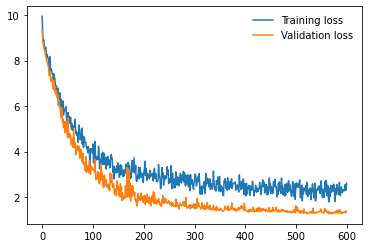

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Loading saved model

In [34]:
model.load_state_dict(torch.load('modelo_clasificacion.pt'))

<All keys matched successfully>

## Test your model

In [35]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    #print("-> Correct: ",correct.shape)
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        #print(i,"Label:{} - Correct: {} ".format(label,correct.shape))
        #print(i,"Correct[i].item(): ",correct[i].item())
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.125732

Test Accuracy of     1: 95% (92/96)
Test Accuracy of     0: 98% (125/127)
Test Accuracy of     2: 70% (12/17)

Test Accuracy (Overall): 95% (229/240)


## Conclusión

Dentro de las combinaciones de las configuraciones para los distintos parámetros e hiperparámetros se pudo obtener que con la siguiente configuración se obtuvieron los mejores resultados:
    - Learning Rate de 0.05. Se probó con 0.01, 0.05, 0.1 y 1.
    - 1 Capa de entrada (35 características), 1 oculta (de 18 a 9 perceptrones, fully connected) y 1 de salida (9 perceptrones a 3 de clases). Se probó aumentando la cantidad de capas ocultas a 3, en total, pero la precisión bajó al 52% dado que se especializaba en la clasificación de la clase 0.
    - 400 épocas. inicialmente se probó con 25 épocas, pero a medida que se iba aumentando de 25 en 25, la precisión iba aumentando; logrando una mayor precisión a las 400 épocas, luego de esta cantidad se mantiene la precisión.

Para este análisis se contaron con un total de 1200 registros, de los cuales se usaron el 80% para entrenamiento y validación; y el 20 % para pruebas. Para fines teóricos se utilizó una semilla con valor 3 de manera que siempre se obtenga el mismo resultado de precisión.